# Experiments with PDFA Specification Synthesis

Nicholas Renninger

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2

from wombats.automaton import Automaton
from wombats.automaton import active_automata
from wombats.utils import get_experiment_paths
from wombats.learning import FlexfringeInterface

# setting all paths
EXPERIMENT_NAME = 'basic_synthesis_experiments'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
TS_MODEL_CONFIG_FILE = path_data['TS_MODEL_CONFIG_FILE']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

## Preparing the Experiment

Loading in the PDFA specification model:

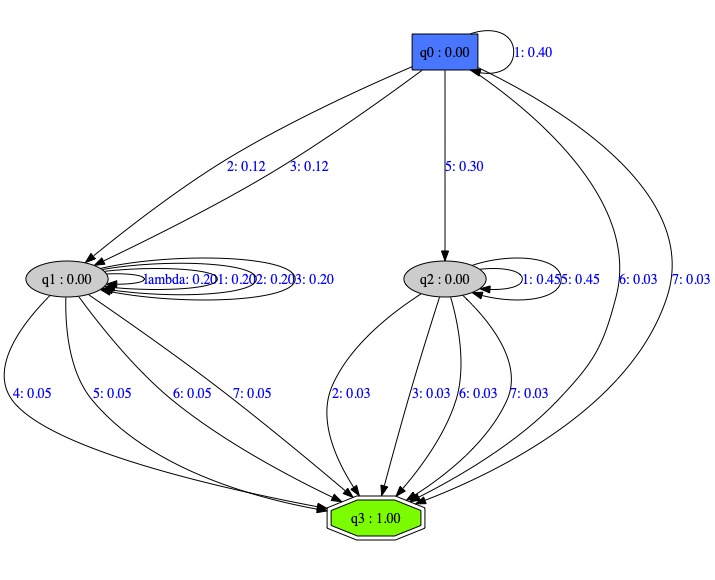

Trace: ['5', '1', '1', '6']
Probability of trace in language of the model: 0.0015187500000000001
Approximate Cross-Entropy of Trace: 2.340724968985917


In [3]:
%autoreload 2

pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)
pdfa_specification.draw('_'.join([EXPERIMENT_NAME, 'PDFA_specification']))

(trace, trace_len,
 trace_prob) = pdfa_specification.generate_trace(pdfa_specification.start_state, N=20)
trace_crossent = pdfa_specification.cross_entropy_approx(trace)

print('Trace:', trace)
print('Probability of trace in language of the model:', trace_prob)
print(f'Approximate Cross-Entropy of Trace: {trace_crossent}')

In [4]:
pdfa_specification.most_probable_string(min_string_probability=0.0001,
                                        max_string_length=100)

(['7'], 0.025, <wombats.utils.MaxHeap at 0x7fb7efec0d50>)

Loading in the Transition System (TS) model:

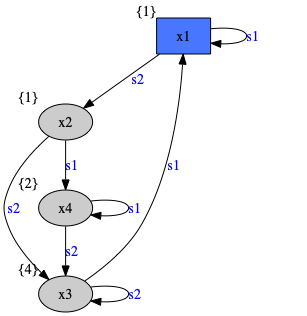

In [5]:
transition_system = active_automata.get(automaton_type='TS',
                                        graph_data=TS_MODEL_CONFIG_FILE)

transition_system.draw('_'.join([EXPERIMENT_NAME, 'TS']))

In [6]:
word = ['s2', 's1', 's2']
print(transition_system.run(word))

(['1', '1', '2', '4'], ['x1', 'x2', 'x4', 'x3'])


In [7]:
print(transition_system.generate_trace(transition_system.start_state,
                                       N=10, return_whatever_you_got=True))

(['s2', 's2', 's1', 's2', 's1', 's2', 's1', 's2', 's2', 's2'], 10, 0.0)


/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/automaton/base.py:532: RuntimeWarning: tried resampling a non-zero probability trace 10 times and failed. Try increasing the current max trace length 10 and checking that at least one reachable state has a non-zero final-state probability.
  warnings.warn(msg, RuntimeWarning)


## PDFA ⊗ TS Product


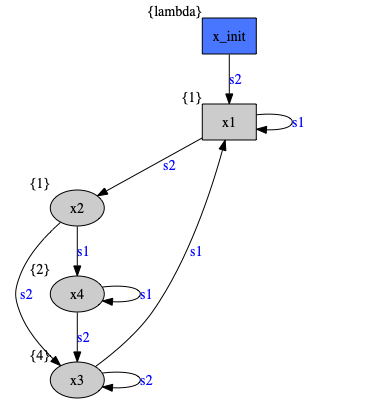

In [8]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(transition_system,
                                          pdfa_specification),
                              show_steps=True)

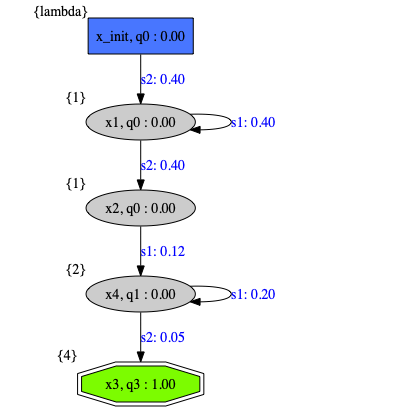

In [9]:
product.draw('_'.join([EXPERIMENT_NAME, 'product']))

## Probabilistic Synthesis on the Product

Here, we are going to compute the most probable string on the product automaton.

In [10]:
controls, prob_of_controls_under_spec = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')


Optimal Controls: ['s2', 's1', 's2']
Probability of Generated TS Observations in Spec: 0.0010000000000000002


### Applying Controller to Original System

In [11]:
output_string, visited_states = transition_system.run(controls)

print(f'Output word of run: {output_string}')
print(f'Output state sequence of run: {visited_states}')

Output word of run: ['1', '1', '2', '4']
Output state sequence of run: ['x1', 'x2', 'x4', 'x3']


### Verifying Language Equivalence of Product MPS and PDFA

We now want to feed the output word of the MPS controller applied to the TS into our specification and verify we get the same probability of generation:

In [12]:
prob_of_run_proj_on_PDFA = pdfa_specification.score(output_string)

print('Probability of product MPS run on TS when projected on PDFA: ',
      prob_of_run_proj_on_PDFA)

Probability of product MPS run on TS when projected on PDFA:  0.0010000000000000002
